## File for locate bruise
##### Tresholds, og alt det der

In [46]:
import numpy as np
import spectral as sp
import matplotlib.pyplot as plt
import cv2
from sklearn import svm

from functions import *

number of bruised = 8835
number of healthy = 6097
(14932, 186)
(14932,)


SVC()

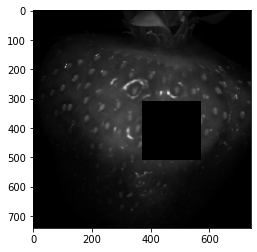

In [47]:
names = np.array(["before-hit", "0m","30m","1h" ,"3h","12h", "24h", "48h"])

strawberryCube = sp.open_image(getImage("12h"))

N,M,BANDS = strawberryCube.shape
#strawberry = strawberryCube.read_subregion((4700,N), (0,666)) # strawberry ID 1 (750,M)
                                                            # strawberry ID 2 (0,666)
#sp.imshow(strawberry[:,:,180])


    # center of each strawberry sorted on IDs, starting with 1
strawberryCoords = np.array([[1224, 5090, 740]])#, [333 ,5060, 666]])
#bruises = np.array([[237, 5075, 3], [1337, 5111, 3]])  Coords on cube 

strawberries = []  # List of whole strawberries

for coord in strawberryCoords:
    strawberries.append(getRegion(strawberryCube, coord[0], coord[1], coord[2]))
    #sp.imshow(getRegion(strawberryCube, coord[0], coord[1], coord[2])[:,:,180], figsize=(10,10), title="getregion 1")
strawberries = np.array(strawberries)

    # center of bruised area with given radius on different strawberries
bruises = np.array([[470, 410, 200]])#, [220, 340, 200]]) 
bruisetrain = np.array([[470, 410, 100]])#, [220, 340, 30]]) 


X_train = []
y_train = []

for i in range(len(bruisetrain)):

    areaBruised = getRegion(strawberries[i], bruisetrain[i][0], bruisetrain[i][1], bruisetrain[i][2]) # subimage of a bruised area
    noSeeds = removeSeeds(areaBruised)
    n,bands = noSeeds.shape
    X_train.extend(noSeeds)
    print("number of bruised = %d" %n)
    y_train.extend(np.ones(n))
    
    
    # removes the bruised part on the whole strawberry
for i in range(len(strawberries)):
    strawberries[i][bruises[i][1] - bruises[i][2]//2 : bruises[i][1] + bruises[i][2]//2 , 
                    bruises[i][0] - bruises[i][2]//2 : bruises[i][0] + bruises[i][2]//2 , : ] = 0
    #sp.imshow(strawberries[i][:,:,180])

for strawberry in strawberries:
    
    mask = strawberryMask(strawberry)
    
    index = np.where(mask==1)
    values = strawberry[index]

    n,bands = values.shape
    X_train.extend(values.reshape(n , bands)[:n//30])
    y_train.extend(np.zeros(n//30))
    print("number of healthy = %d" %(n//30))
    

X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

#y_train.append(np.ones(X_train.shape[0])) # labeled 1 for all brusied spectrums



svm = svm.SVC() 
svm.fit(X_train, y_train)



ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1.0]
    G: [0.0, 1.0]
    B: [0.0, 1.0]

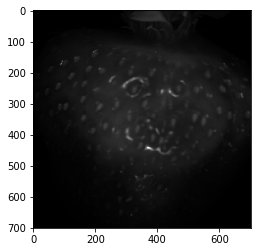

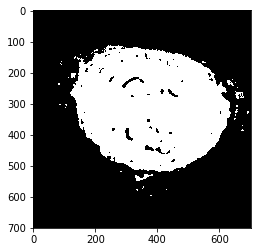

In [49]:
#from joblib import dump, load
#dump(svm, 'svm.joblib') 

testimg = getRegion(strawberryCube,1224, 5090, 700)

mask = strawberryMask(testimg)
n,m,Bands = testimg.shape
X_test = testimg.reshape((n*m,Bands)) # just healthy data 

pred = svm.predict(X_test)
#pred[20:25] = 0
predimg = pred.reshape((n,m))

sp.imshow(testimg[:,:,180])

sp.imshow(predimg*mask)


#sp.imshow(X_train)


In [ ]:
names = np.array(["before-hit", "0m","30m","1h" ,"3h","12h", "24h", "48h"])

strawberryCube = sp.open_image(getImage("12h"))
strawberryCubeBefore = sp.open_image(getImage("before-hit"))
N,M,Bands = strawberryCube.shape
strawberry = strawberryCube.read_subregion((4700,N), (0,666)) # strawberry ID 1 (750,M)
                                                            # strawberry ID 2 (0,666)
sp.imshow(strawberry[:,:,180])

bruise = getRegion(strawberry, 225, 400, 3) # 
print(bruise.shape)


test8bit = (bruise[:,:,180]*255).astype('uint8')
thresh = cv2.threshold(test8bit, np.mean(test8bit),1, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1] # inverse otsu threshold
sp.imshow(bruise[:,:,180], cmap="gray")

a = np.where(thresh==1)

X_train = bruise[a]
print(X_train.shape)




In [ ]:
names = np.array(["before-hit", "0m","30m","1h" ,"3h","12h", "24h", "48h"])

strawberryCube = sp.open_image(getImage("12h"))
N,M,Bands = strawberryCube.shape
strawberry = strawberryCube.read_subregion((4700,N), (0,666)) # strawberry ID 1 (750,M)
                                                              # strawberry ID 2 (0,666)

sp.imshow(strawberry[:,:,180],figsize=(5,10))



test = strawberry[:,:,180]
test8bit = (test*255).astype('uint8')
#th3 = cv2.adaptiveThreshold(test8bit,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,21,1)
tresh = cv2.threshold(test8bit,10,255, cv2.THRESH_BINARY)[1]
kernel = np.ones((7,7),np.uint8)
closing  = cv2.morphologyEx(tresh, cv2.MORPH_CLOSE, kernel, iterations=1)
erode = cv2.erode(closing,kernel, iterations =10)

#mask = erode
kernel = np.ones((3,3),np.uint8)

imggrad =  (cv2.dilate(test,kernel) - cv2.erode(test,kernel)) #* mask

imggrad[imggrad < imggrad[300,210]] = 0
imggrad[imggrad >= imggrad[300,210]] = 1
eroded = cv2.dilate(cv2.erode(imggrad,kernel, iterations =5),kernel,iterations =2)

sp.imshow(eroded,figsize=(5,10))

imgNoSeeds = test*(1-eroded)

sp.imshow(imgNoSeeds,figsize=(5,10))


